In [34]:
import geopandas as gpd
from shapely.geometry import Point
import googlemaps

map = "City_of_Pittsburgh_Neighborhoods.shp" # Path to the shapefile

data = gpd.read_file(map).to_crs("EPSG:4326") #convert the map into a latitude/longitude coordinate system

#func takes lat/lon coordinates and returns the neighborhood name
def get_neighborhood(lat, lon):
    #create a point with coordinates
    point = Point(lon, lat)  
    #iterate through each neighborhood in map to check if contains point and return the name of the neighborhood
    for col, row in data.iterrows(): 
        if row['geometry'].contains(point):
            return row['HOOD'] 
    return "Neighborhood not found"

key = input("Enter your Google API key: ") #So I don't expose my key in a public github repo and lose millions of dollars
gmaps = googlemaps.Client(key=key)

#method to get lat/lon given an address, uses google api
def getLatLon(address):
    geocodeResult = gmaps.geocode(address) 
    if geocodeResult: #check if the geocode result is not empty
        location = geocodeResult[0]['geometry']['location'] #extract the location from the result
        #get the lat/lon from the location
        lat = location['lat']   
        lon = location['lng']
        return lat, lon
    else:
        return None, None

ValueError: Must provide API key or enterprise credentials when creating client.

In [35]:
FinalScore = {}

The Method's above were created in order to identify a Pittsburgh neighborhood given either the longitude and latitute or a street address. This allowed us to incorporate datasets that didn't explicity identify neighborhoods. We used Geopandas to use the pittsburgh neighborhood map, and google maps api to find longitude and latitute given an address. 

In [36]:
import csv
neighborhoods = {} #blank dictionary
with open("PogoStations.csv", "r") as pogos:
    reader = csv.reader(pogos)
    next(reader) #skip header row
    for row in reader: #read each row
        latitude = float(row[4]) #row with lat
        longitude = float(row[5])#row with lon
        neighborhood = get_neighborhood(latitude, longitude) #call method defined above to get hood
        if neighborhood in neighborhoods: #check if in dict
            neighborhoods[neighborhood] += 1 #add 1 to value
        else: #new neighborhood
            neighborhoods[neighborhood] = 1 #set intial value to 1

maxPogo = max(neighborhoods.values()) #find the max value in the dict
BikeScore = []
Neigborhood = []
for neighborhood in neighborhoods:
    BikeScore.append( (neighborhoods[neighborhood])/(maxPogo)*100)
    Neigborhood.append(neighborhood) 
    FinalScore[neighborhood] = (neighborhoods[neighborhood])/(maxPogo)*100 

#print(BikeScore)

The first metric we calculated was the Bike Score. When choosing where to live, it is important to have access to transportation, and POGOH bikes are on of the most convenient methods of travel. We calculated this score by finding the number of POGOH stations in each Neighborhood and then standardizing this number between 0-100 to give the final bike score. 

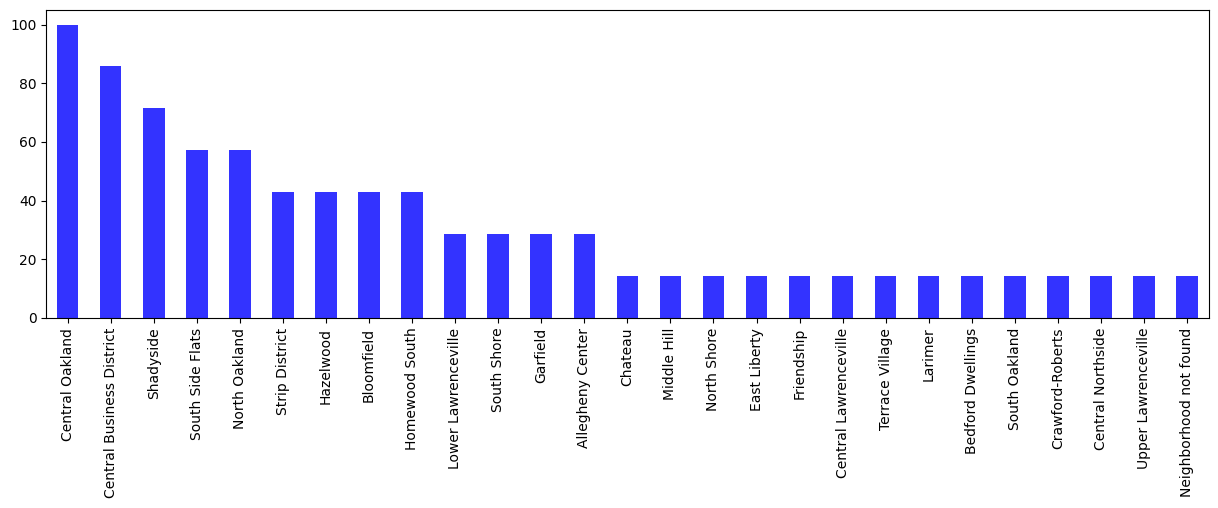

In [37]:
import pandas as pd

df = pd.Series(BikeScore, index = Neigborhood).sort_values(ascending = False).plot.bar(alpha = 0.8, color = 'blue', figsize = (15, 4))

From the bar chart; Central Oakland, Downtown and Shadyside have the best Bike scores. Any of the neighborhoods not represented have a Bike Score of 0.

In [38]:
Neighborhoods = {}
with open("blockParty.csv", "r") as pogos:
    reader = csv.reader(pogos)
    next(reader)
    for row in reader:
        coordinates = getLatLon(row[3] + " pittsburgh, pa")
        neighborhood = get_neighborhood(coordinates[0], coordinates[1])
        if neighborhood in Neighborhoods:
            Neighborhoods[neighborhood] += 1
        else:
            Neighborhoods[neighborhood] = 1

#print(Neighborhoods) 

MaxScore = max(Neighborhoods.values())
DaHood = []
partyScore = []

for hood in Neighborhoods:
    DaHood.append(hood)
    partyScore.append((Neighborhoods[hood]/MaxScore)*100) 
    if(hood in FinalScore):
        FinalScore[hood] += (Neighborhoods[hood]/MaxScore)*100
    else:   
        FinalScore[hood] = (Neighborhoods[hood]/MaxScore)*100

The next metric we decided upon was the Party Score. No one wants to live in a boring neighborhood, so one of the metrics we took into account was the number of block parties scheduled in each neighborhood throughout the year. The method we used was similar to that of the Bike Score. The main difference was that dataset only had the address of the party. To work with this dataset, we used the Google Maps Api to determine the coordinates of the address listed, and then used those coordinates to identify the neighborhood. Once again we collected the number of Block Parties in eahc neighborhood and then standardized between 0-100 to give the final Party Score. 

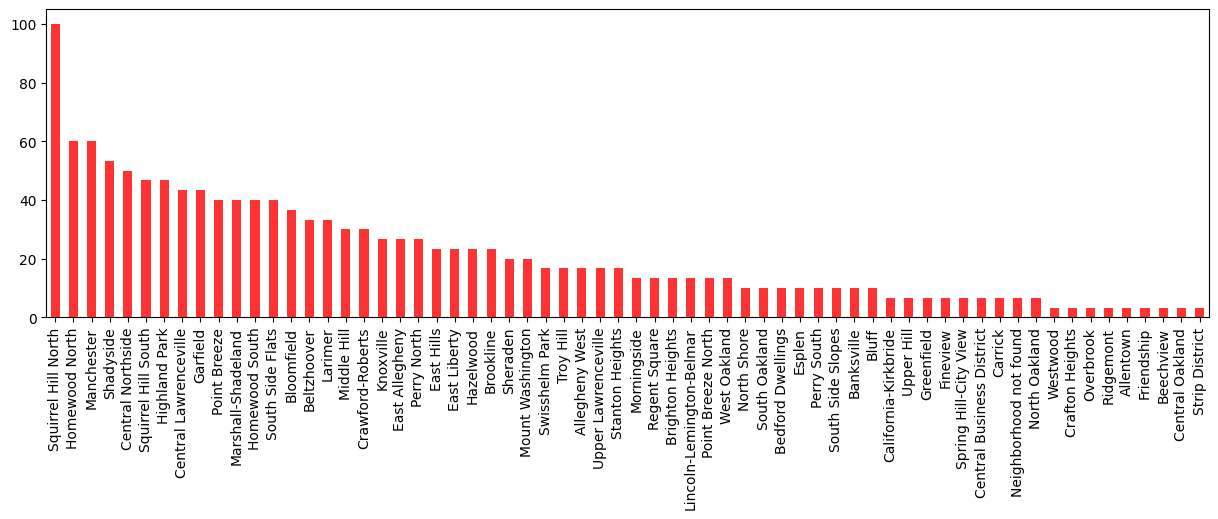

In [39]:
df2=pd.Series(partyScore, index = DaHood).sort_values( ascending= False).plot.bar(alpha = 0.8, color = 'red', figsize = (15, 4))

By far, the best neighborhood for partying is Squirrel Hill North. Some other bumping neighborhoods include: Manchester, Homewood North and Shadyside. 

In [40]:
import csv
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

def get_neighborhood(lat, lon):
    point = Point(lon, lat)  
    for col, row in data.iterrows():
        if row['geometry'].contains(point):
            return row['HOOD'] 
    return "Neighborhood not found"

map = "City_of_Pittsburgh_Neighborhoods.shp"

data = gpd.read_file(map).to_crs("EPSG:4326")

neighborhoods = {}
with open("arrest_data.csv", "r") as arrests:
    reader = csv.reader(arrests)
    next(reader)
    for row in reader:
        if (row[15] != "None" and row[16] != "None" and row[15] != "" and row[16] != ""):
            latitude = float(row[16])
            longitude = float(row[15])
            neighborhood = get_neighborhood(latitude, longitude)
            if neighborhood in neighborhoods:
                neighborhoods[neighborhood] += 1
            else:
                neighborhoods[neighborhood] = 1
maxCrime = max(neighborhoods.values())
minCrime = min(neighborhoods.values())

crimeScore = []
Neighborhood2 = []
for neighborhood in neighborhoods:
    crimeScore.append((maxCrime - neighborhoods[neighborhood])/(maxCrime - minCrime) * 100)
    Neighborhood2.append(neighborhood) 
    if(neighborhood in FinalScore):
        FinalScore[neighborhood] += ((maxCrime - neighborhoods[neighborhood])/(maxCrime - minCrime) * 100)
    else:
        FinalScore[neighborhood] = ((maxCrime - neighborhoods[neighborhood])/(maxCrime - minCrime) * 100)
#print(crimeScore)



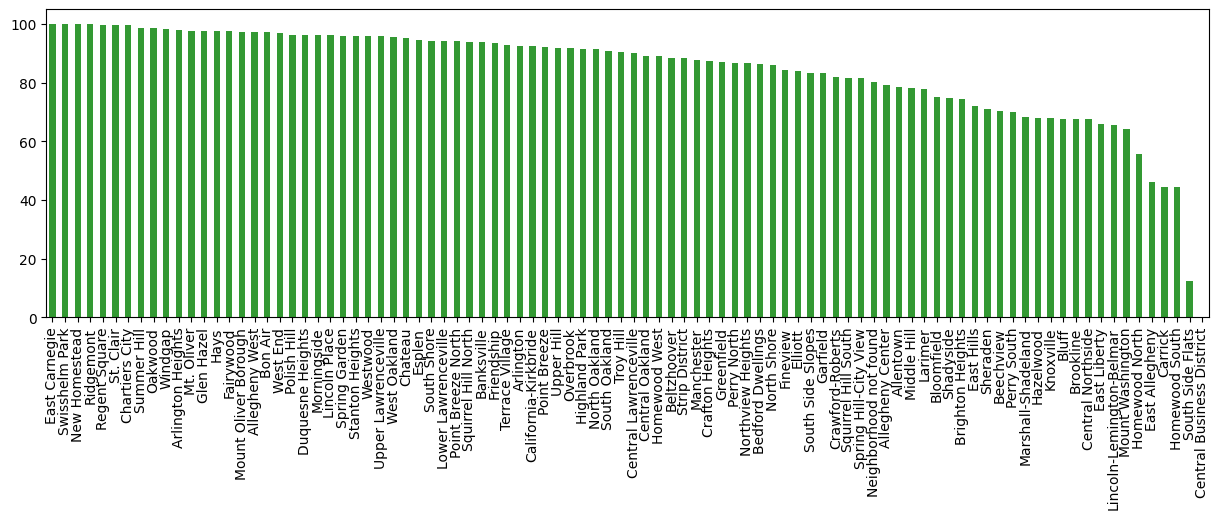

In [41]:
df3=pd.Series(crimeScore, index = Neighborhood2).sort_values( ascending=False).plot.bar(alpha = 0.8, color = 'green', figsize = (15, 4))

The final metric we took into account was Crime. Safety is a crucial factor when it comes to being the best neighborhood. No one wants to live in an unsafe area. This metric was gained from taking the arrest data of Pittburgh in a similar fashion to Pogo's. This allows us to graph the amount of arrests each neighborhood has and from there you can see the neighborhoods with the most crime, and more importantly the least.

{'Shadyside': 199.53072906837767, 'Hazelwood': 134.19576020632826, 'Middle Hill': 122.48914889601812, 'Strip District': 134.51280115745107, 'Chateau': 109.63578033591244, 'Central Business District': 92.38095238095238, 'Bloomfield': 154.5304145436246, 'South Shore': 122.75901113417625, 'South Side Flats': 109.40177391960746, 'Central Oakland': 192.36900044033467, 'North Oakland': 155.14373781216582, 'Homewood South': 127.19003585582186, 'Central Lawrenceville': 147.7643580549789, 'North Shore': 110.3094923570485, 'Lower Lawrenceville': 122.73259105491601, 'East Liberty': 103.61640561112159, 'Garfield': 155.02233125746994, 'Friendship': 111.04044788324842, 'Terrace Village': 107.23155312323081, 'Larimer': 125.58470151600932, 'South Oakland': 115.22362709945273, 'Bedford Dwellings': 110.78505378373276, 'Crawford-Roberts': 126.05585959615021, 'Allegheny Center': 107.62030571806001, 'Central Northside': 131.81543687488204, 'Upper Lawrenceville': 126.80442850852363, 'Neighborhood not found'

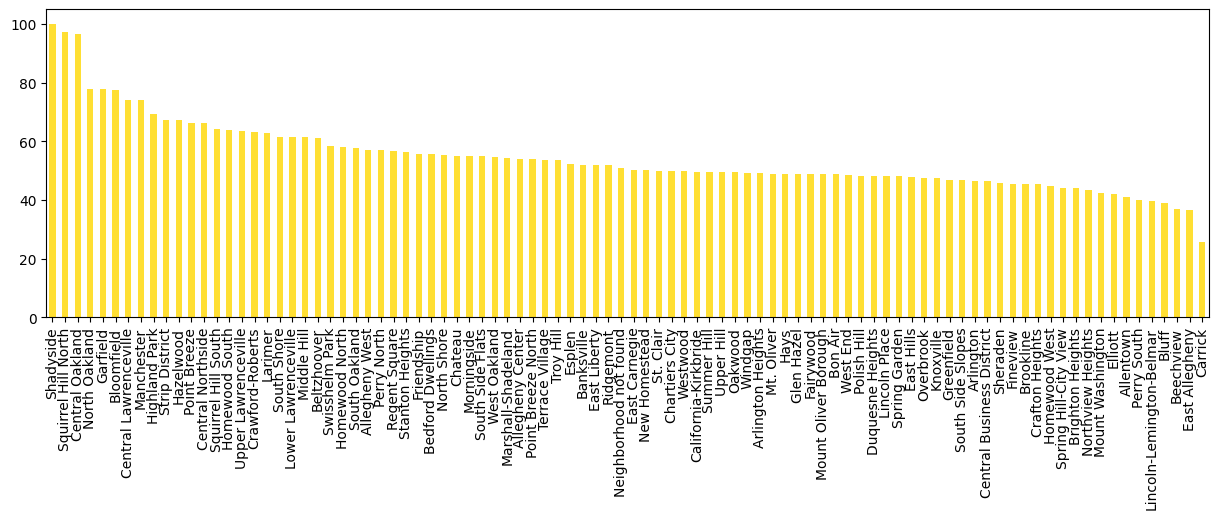

In [42]:
print(FinalScore)

neigh = []
score =[]

maxScore = max(FinalScore.values())

for neighborhood in FinalScore:
    neigh.append(neighborhood)
    score.append((FinalScore[neighborhood]/maxScore)*100)

finalDf=pd.Series(score, index = neigh).sort_values( ascending=False).plot.bar(alpha = 0.8, color = 'gold', figsize = (15, 4))




This final graph shows the combined scores between all the metrics. This allows us to find the best neighborhood according to our standards which is based on Pogo Bike access, number of block parties, and crime. Shadyside, has the highest combined score with Squirrel Hill North and Central Oakland following close behind.